In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses

## Problem Description

This project uses generative adversarial networks (GANs) to modify a set of images to look like Claude Monet images. This is a Kaggle competition at https://www.kaggle.com/competitions/gan-getting-started.

GAN architectures rely on two copmeting models: a generator and a discriminator. The generator creates the new images, learning over time to make them more Monet-like. The discriminator is trained to identify real and fake images. These two models go back and forth during training, the generator creating increasingly Monet-like images, and the discriminator calling out the fake images. Eventually the created images are good enough that the discriminator can no longer distinguish real from fake images. At this point, our GAN is able to create lifelike or Monet-like images that are indistinguishable from real ones, at least to the discriminator.

This project has a set of Monet images and a set of images that we need to modify with the GAN to look like Monet images. We will explore both sets of images before turning to architecting, training, and evaluating GANs.

The competition asks us to submit a zipped collection of generated images in order to receive a score.

## Preprocessing & Exploratory Data Analysis (EDA)

This competition provides both sets of images as JPGs and as TensorFlow TFRecord file formats for storing a sequence of binary records. We will work with the TFRecords to figure out how that format works.

TFRecords serialize structured data into binary strings. We need to know what features or keys exists for each element in the TFRecord collection. The images we are working with here have three features: `image_name`, `image`, and `target`. These are set when turning data into the TFRecord format.

The Kaggle documentation tells us that the images are all 256 x 256 pixels and are color images with the standard three RGB channels.

In [2]:
in_dir = '/kaggle/input/gan-getting-started'
out_dir = '/kaggle/working'

monet_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/monet_tfrec')
monet_jpg_names = tf.io.gfile.listdir(f'{in_dir}/monet_jpg')
photo_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/photo_tfrec')
photo_jpg_names = tf.io.gfile.listdir(f'{in_dir}/photo_jpg')

print(f'There are {len(monet_tfrec_names)} Monet TFRecord collections')
print(f'There are {len(monet_jpg_names)} Monet jpgs in total')
print(f'There are {len(photo_tfrec_names)} photo TFRecord collections')
print(f'There are {len(photo_jpg_names):,} photo jpgs in total')
print()
print(f'Sample of what the TFRecord files look like: {monet_tfrec_names}')

There are 5 Monet TFRecord collections
There are 300 Monet jpgs in total
There are 20 photo TFRecord collections
There are 7,038 photo jpgs in total

Sample of what the TFRecord files look like: ['monet12-60.tfrec', 'monet16-60.tfrec', 'monet08-60.tfrec', 'monet04-60.tfrec', 'monet00-60.tfrec']


In [3]:
# Find what the current tfrec files are storing as features for each record
ex = tf.train.Example()
ex.ParseFromString(
    next(iter(tf.data.TFRecordDataset(f'{in_dir}/monet_tfrec/{monet_tfrec_names[0]}').take(1))).numpy()
)
[k for k in ex.features.feature.keys()]

['image', 'target', 'image_name']

In [4]:
# Extract records from tfrec files into TFRecordDataset collection
tfrecs_monet = tf.data.TFRecordDataset([f'{in_dir}/monet_tfrec/{f}' for f in monet_tfrec_names])
tfrecs_photo = tf.data.TFRecordDataset([f'{in_dir}/photo_tfrec/{f}' for f in photo_tfrec_names])
    
# Define the features of the structured data stored in the TFRecord collections
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string)
    , 'image': tf.io.FixedLenFeature([], tf.string)
    , 'target': tf.io.FixedLenFeature([], tf.string)
    
}

# Pull image data out of individual TFRecord elements as dictionary mappings
# and then convert to iamges
def parse_image(record):
    return tf.io.decode_image(
        tf.io.parse_single_example(record, feature_description)['image']
        , channels=3
    )

parsed_images_monet = tfrecs_monet.map(parse_image)
parsed_images_photo = tfrecs_photo.map(parse_image)

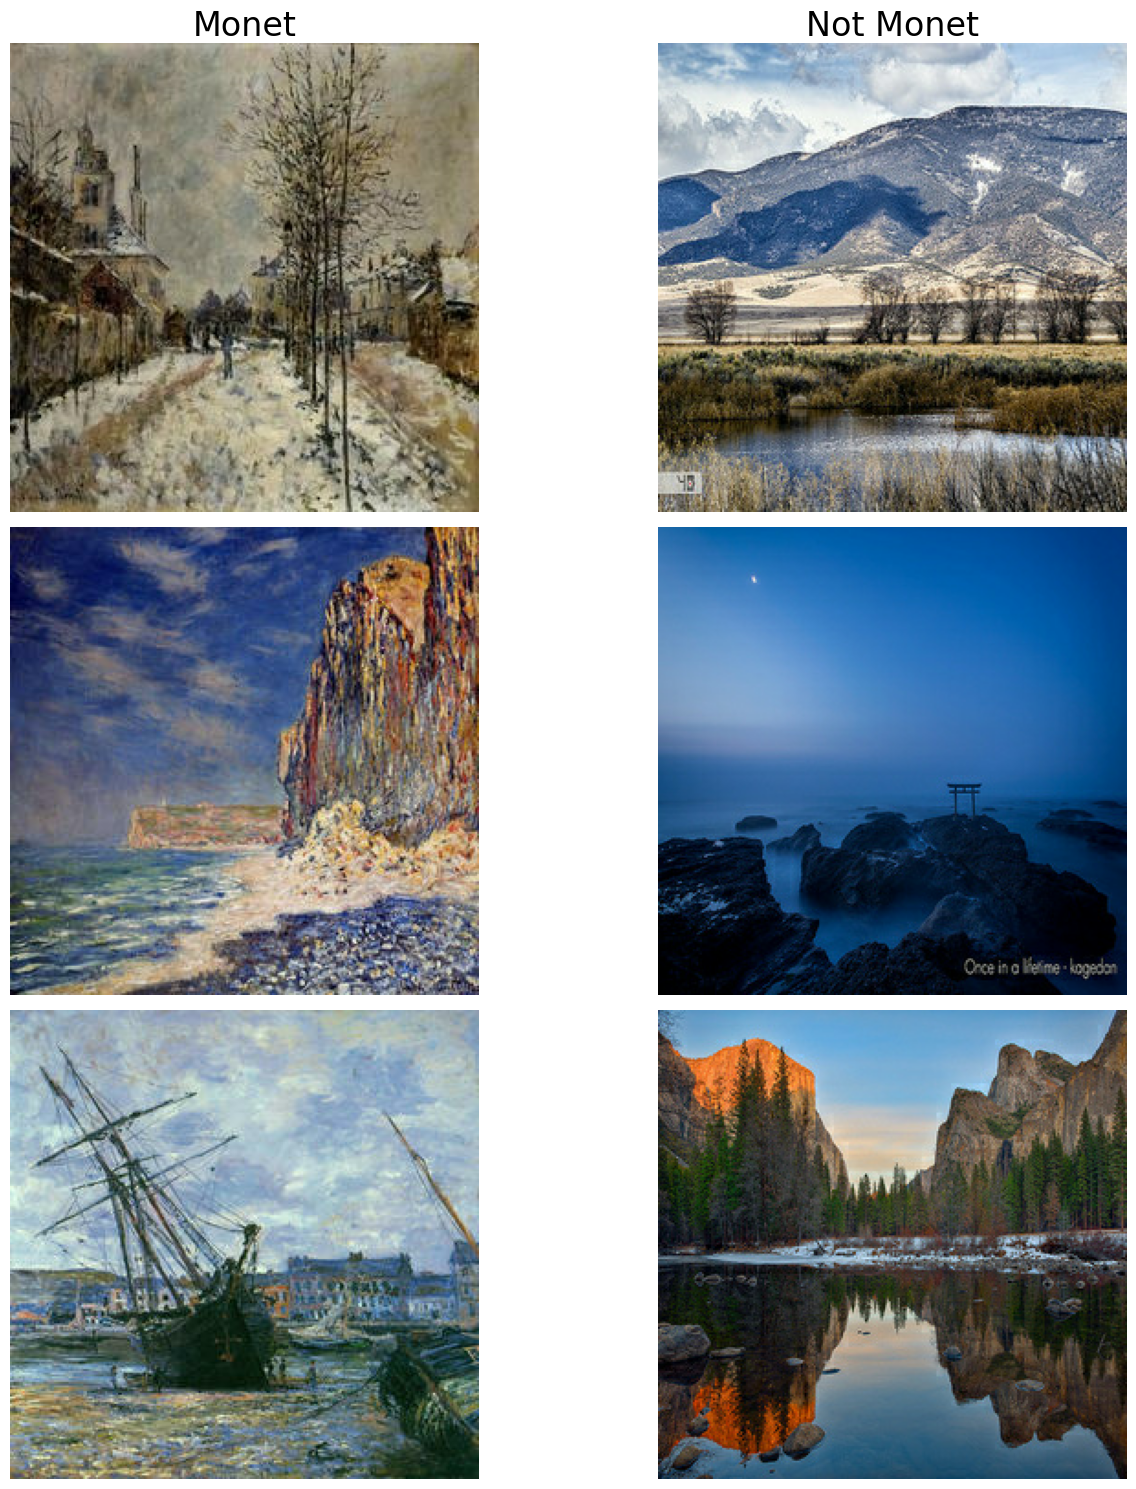

In [5]:
# Display one Monet and one non-Monet image
fig, axes = plt.subplots(
    3
    , 2
    , figsize=(15,15)
)

iter_monet = iter(parsed_images_monet)
iter_photo = iter(parsed_images_photo)

axes[0,0].imshow(next(iter_monet))
axes[0,1].imshow(next(iter_photo))
axes[1,0].imshow(next(iter_monet))
axes[1,1].imshow(next(iter_photo))
axes[2,0].imshow(next(iter_monet))
axes[2,1].imshow(next(iter_photo))

axes[0,0].set_title('Monet', fontsize=24)
axes[0,1].set_title('Not Monet', fontsize=24)

# Turn axis labels and grids off
for ax in axes.ravel():
    ax.set_axis_off()

fig.tight_layout()

We are working with 300 Monet images and 7,038 non-Monet images. The two images above show Monets on the left and non-Monets on the right. The gist of the code above extracts the TFRecord collections into TFRecordDataset datasets and pulls the image pixel data out of each element in the collections.

Next we will explore a couple of aspects of the images to see if we can find a foothold for understanding what makes them up.

I am still working on how to do the next couple of code blocks in TensorFlow, so we will use Numpy in the interim.

`parsed_images_monet` and `parsed_images_photo` are collections of TensorFlow tensors of shape (256, 256, 3). This is what we expect to see based on the Kaggle documentation. We have a 256 x 256 px image with each cell being a 3 dimensional array for the RGB channels. The general approach for the next couple of check will be to see if there are differences between the Monet and non-Monet images in terms of sums or means of values across different dimensions of the tensors.

We will get a sense of what we are working with before moving on to calculating and exploring descriptive statistics for each of the sets of images.

In [6]:
list_monet = np.array([i for i in parsed_images_monet])
list_photo = np.array([i for i in parsed_images_photo])

print(f'Dimensions of Monet image collection: {list_monet.shape}')
print(f'Dimensions of photo image collection: {list_photo.shape}')
print(f'Dimensions of first individual Monet image: {list_monet[0].shape}')
print(f'Dimensions of first individual Monet image: {list_photo[0].shape}')

list_monet[0]

Dimensions of Monet image collection: (300, 256, 256, 3)
Dimensions of photo image collection: (7038, 256, 256, 3)
Dimensions of first individual Monet image: (256, 256, 3)
Dimensions of first individual Monet image: (256, 256, 3)


array([[[138, 125, 106],
        [123, 110,  91],
        [112, 101,  83],
        ...,
        [116, 101,  68],
        [112,  98,  61],
        [108,  94,  57]],

       [[142, 129, 110],
        [135, 122, 103],
        [130, 119, 101],
        ...,
        [136, 121,  88],
        [130, 116,  79],
        [124, 110,  73]],

       [[141, 128, 109],
        [141, 128, 109],
        [143, 132, 114],
        ...,
        [150, 135, 102],
        [142, 128,  93],
        [135, 121,  84]],

       ...,

       [[101,  88,  56],
        [118, 105,  73],
        [105,  91,  62],
        ...,
        [127, 109,  71],
        [123, 105,  67],
        [122, 104,  66]],

       [[ 96,  83,  49],
        [111,  98,  66],
        [107,  94,  62],
        ...,
        [118, 100,  62],
        [117,  99,  61],
        [123, 103,  66]],

       [[108,  95,  61],
        [106,  93,  59],
        [101,  88,  56],
        ...,
        [106,  88,  50],
        [110,  90,  53],
        [120, 100,  63]]

In [7]:
print(f'Example sum of all pixels in image: {np.sum(list_monet[0]):,}')
print(f'Example sum of red channel in image: {np.sum(list_monet[0][:,:,0]):,}')
print(f'Example sum of green channel in image: {np.sum(list_monet[0][:,:,1]):,}')
print(f'Example sum of blue channel in image: {np.sum(list_monet[0][:,:,2]):,}')
print(f'Sanity check: {np.sum(list_monet[0][:,:,0]) + np.sum(list_monet[0][:,:,1]) + np.sum(list_monet[0][:,:,2]):,}')
print(f'Example mean of all pixels in image: {np.mean(list_monet[0]):.2f}')
print(f'Example mean of red channel in image: {np.mean(list_monet[0][:,:,0]):.2f}')
print(f'Example mean of green channel in image: {np.mean(list_monet[0][:,:,1]):.2f}')
print(f'Example mean of blue channel in image: {np.mean(list_monet[0][:,:,2]):.2f}')

Example sum of all pixels in image: 22,389,565
Example sum of red channel in image: 8,204,343
Example sum of green channel in image: 7,766,019
Example sum of blue channel in image: 6,419,203
Sanity check: 22,389,565
Example mean of all pixels in image: 113.88
Example mean of red channel in image: 125.19
Example mean of green channel in image: 118.50
Example mean of blue channel in image: 97.95


I went back and forth on what type exploratory analysis to perform before jumping into GAN modeling. We do not have a label breakdown to check for imbalance. We do not have other classifiers to aggregate against for the training inputs. But we can take a look at the pixel values that create the Monet images and the non-Monet images. For example, we may find that the Monet images tend to have stronger pixel values in the red and blue channels but smaller values in the green channel. This may or may not be useful when comparing against the non-Monet images. Similarly, we may find that the overall pixel mean per image is different between the two sets of images.

We will check out the sum and mean for images across all channels and across each of the RGB channels.

In [8]:
num_images_monet = list_monet.shape[0]
num_images_photo = list_photo.shape[0]

sum_all_channels_monet = []
sum_red_channel_monet = []
sum_green_channel_monet = []
sum_blue_channel_monet = []
mean_all_channels_monet = []
mean_red_channel_monet = []
mean_green_channel_monet = []
mean_blue_channel_monet = []

sum_all_channels_photo = []
sum_red_channel_photo = []
sum_green_channel_photo = []
sum_blue_channel_photo = []
mean_all_channels_photo = []
mean_red_channel_photo = []
mean_green_channel_photo = []
mean_blue_channel_photo = []

for img in list_monet:
    sum_all_channels_monet.append(np.sum(img))
    sum_red_channel_monet.append(np.sum(img[:,:,0]))
    sum_green_channel_monet.append(np.sum(img[:,:,1]))
    sum_blue_channel_monet.append(np.sum(img[:,:,2]))
    mean_all_channels_monet.append(np.mean(img))
    mean_red_channel_monet.append(np.mean(img[:,:,0]))
    mean_green_channel_monet.append(np.mean(img[:,:,1]))
    mean_blue_channel_monet.append(np.mean(img[:,:,2]))

for img in list_photo:
    sum_all_channels_photo.append(np.sum(img))
    sum_red_channel_photo.append(np.sum(img[:,:,0]))
    sum_green_channel_photo.append(np.sum(img[:,:,1]))
    sum_blue_channel_photo.append(np.sum(img[:,:,2]))
    mean_all_channels_photo.append(np.mean(img))
    mean_red_channel_photo.append(np.mean(img[:,:,0]))
    mean_green_channel_photo.append(np.mean(img[:,:,1]))
    mean_blue_channel_photo.append(np.mean(img[:,:,2]))

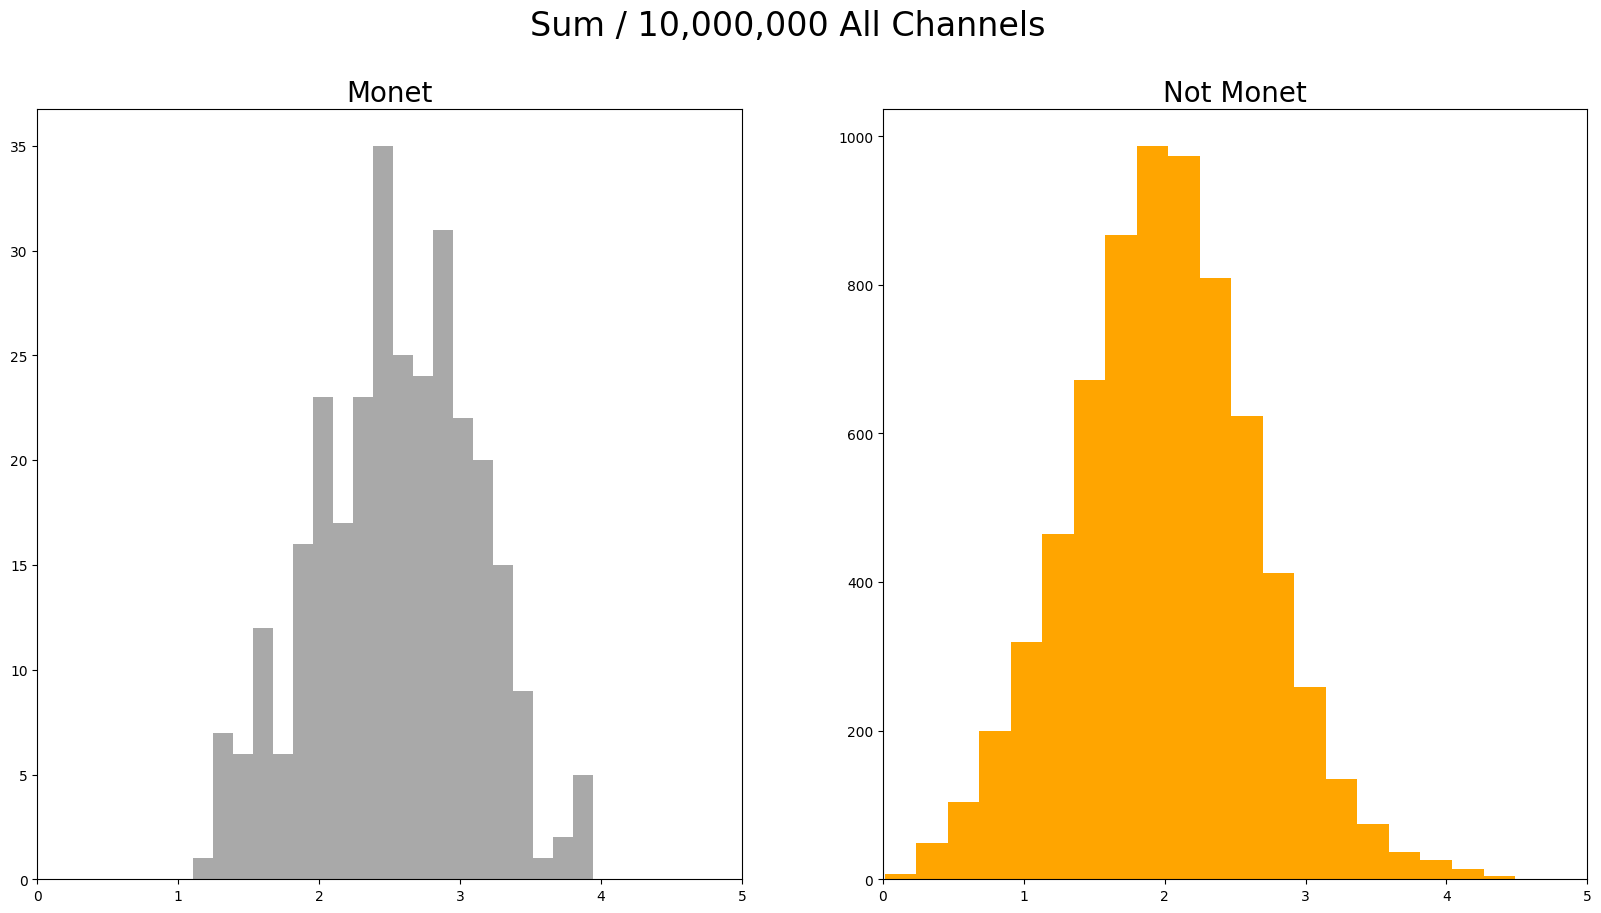

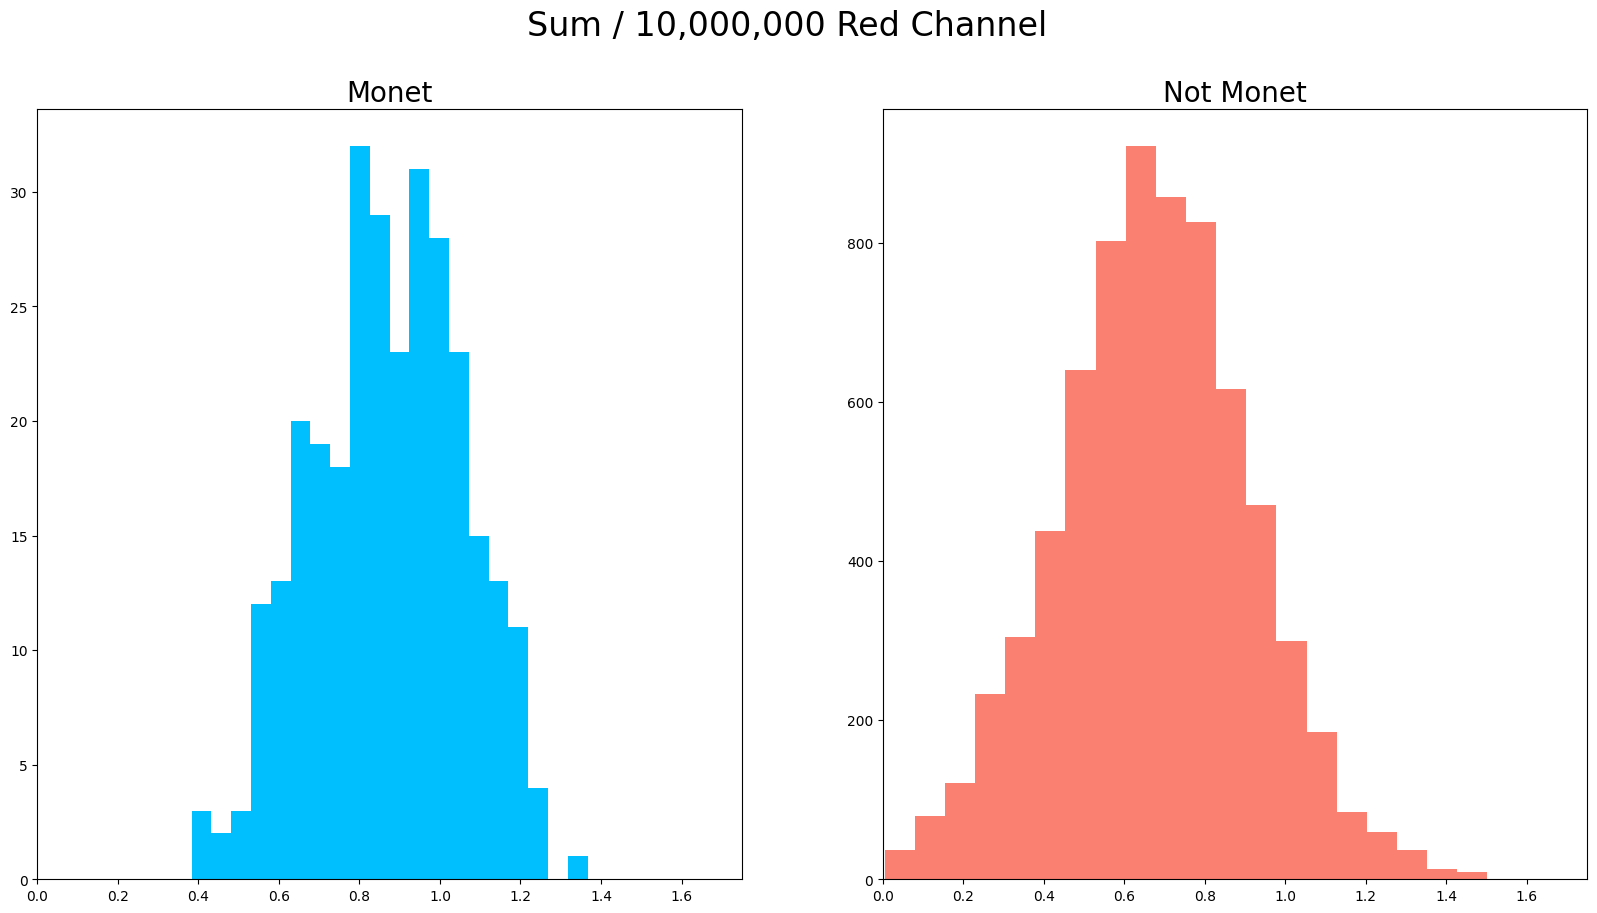

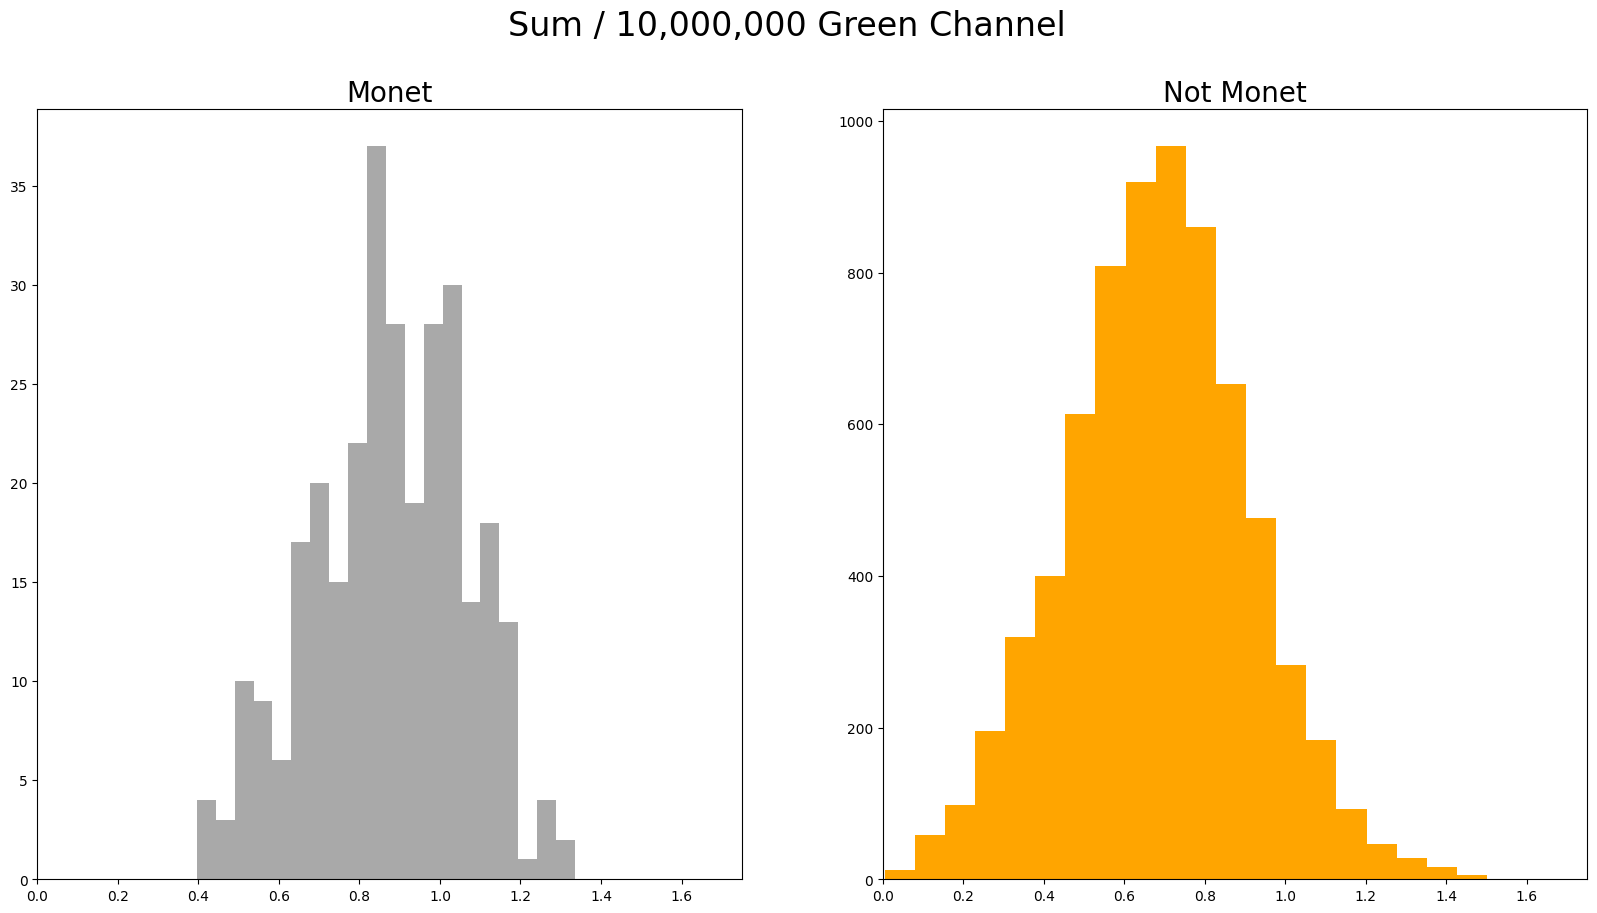

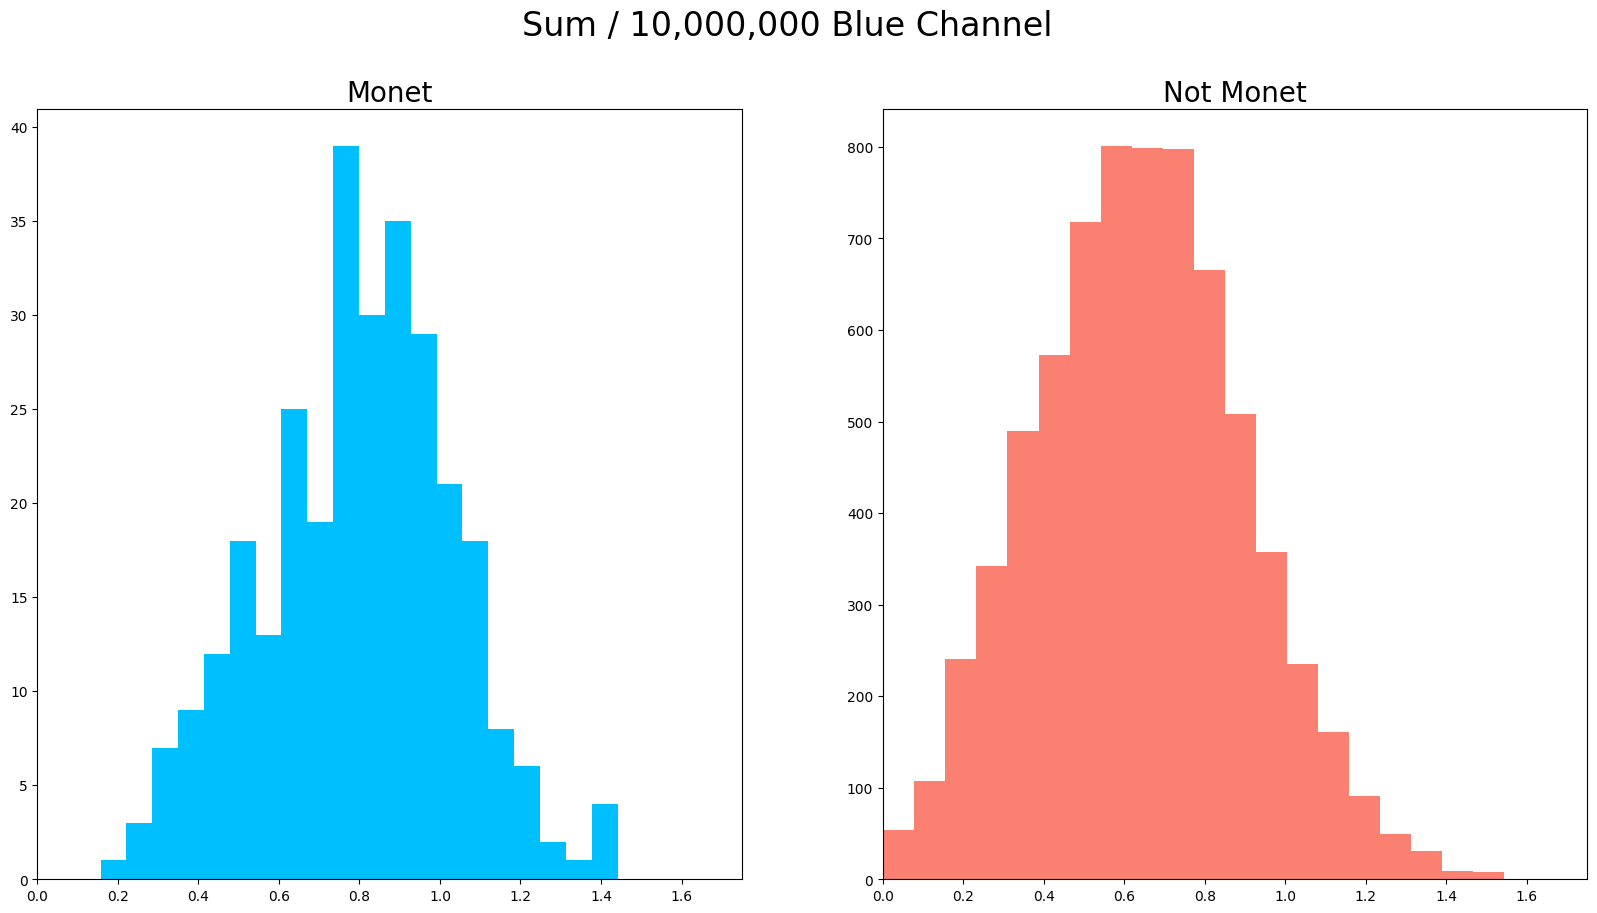

In [9]:
# Sum All
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_all_channels_monet)/10000000, bins=20, color='darkgray');
axes[1].hist(np.array(sum_all_channels_photo)/10000000, bins=20, color='orange');
fig.suptitle('Sum / 10,000,000 All Channels', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,5]);
axes[1].set_xlim([0,5]);



# Sum Red
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_red_channel_monet)/10000000, bins=20, color='deepskyblue');
axes[1].hist(np.array(sum_red_channel_photo)/10000000, bins=20, color='salmon');
fig.suptitle('Sum / 10,000,000 Red Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,1.75]);
axes[1].set_xlim([0,1.75]);



# Sum Green
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_green_channel_monet)/10000000, bins=20, color='darkgray');
axes[1].hist(np.array(sum_green_channel_photo)/10000000, bins=20, color='orange');
fig.suptitle('Sum / 10,000,000 Green Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,1.75]);
axes[1].set_xlim([0,1.75]);



# Sum Blue
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(np.array(sum_blue_channel_monet)/10000000, bins=20, color='deepskyblue');
axes[1].hist(np.array(sum_blue_channel_photo)/10000000, bins=20, color='salmon');
fig.suptitle('Sum / 10,000,000 Blue Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,1.75]);
axes[1].set_xlim([0,1.75]);

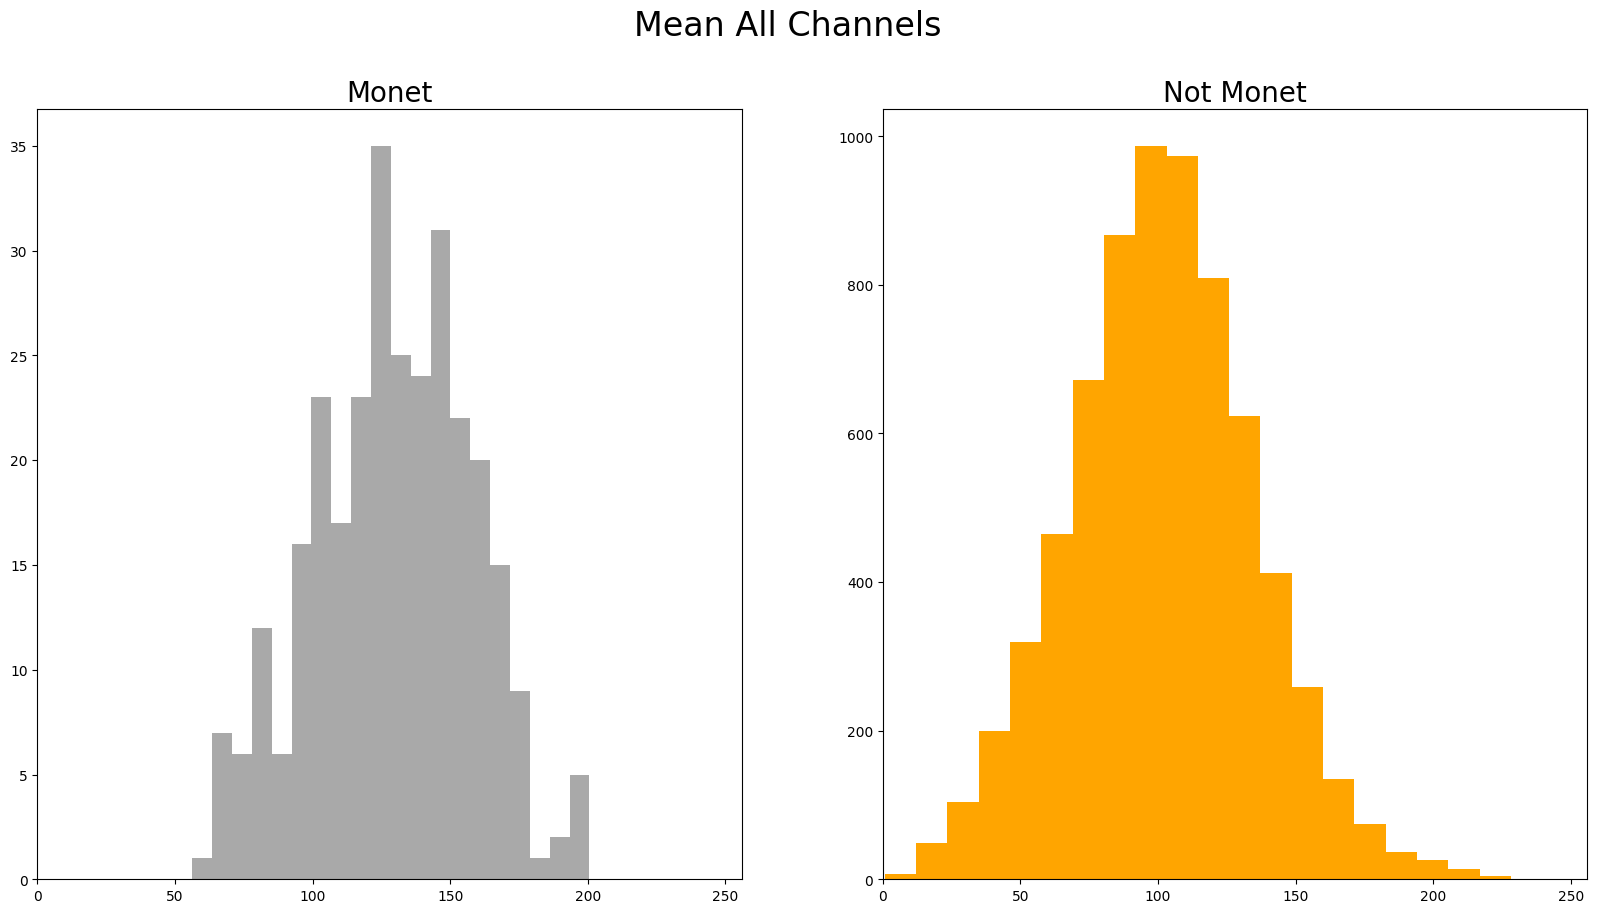

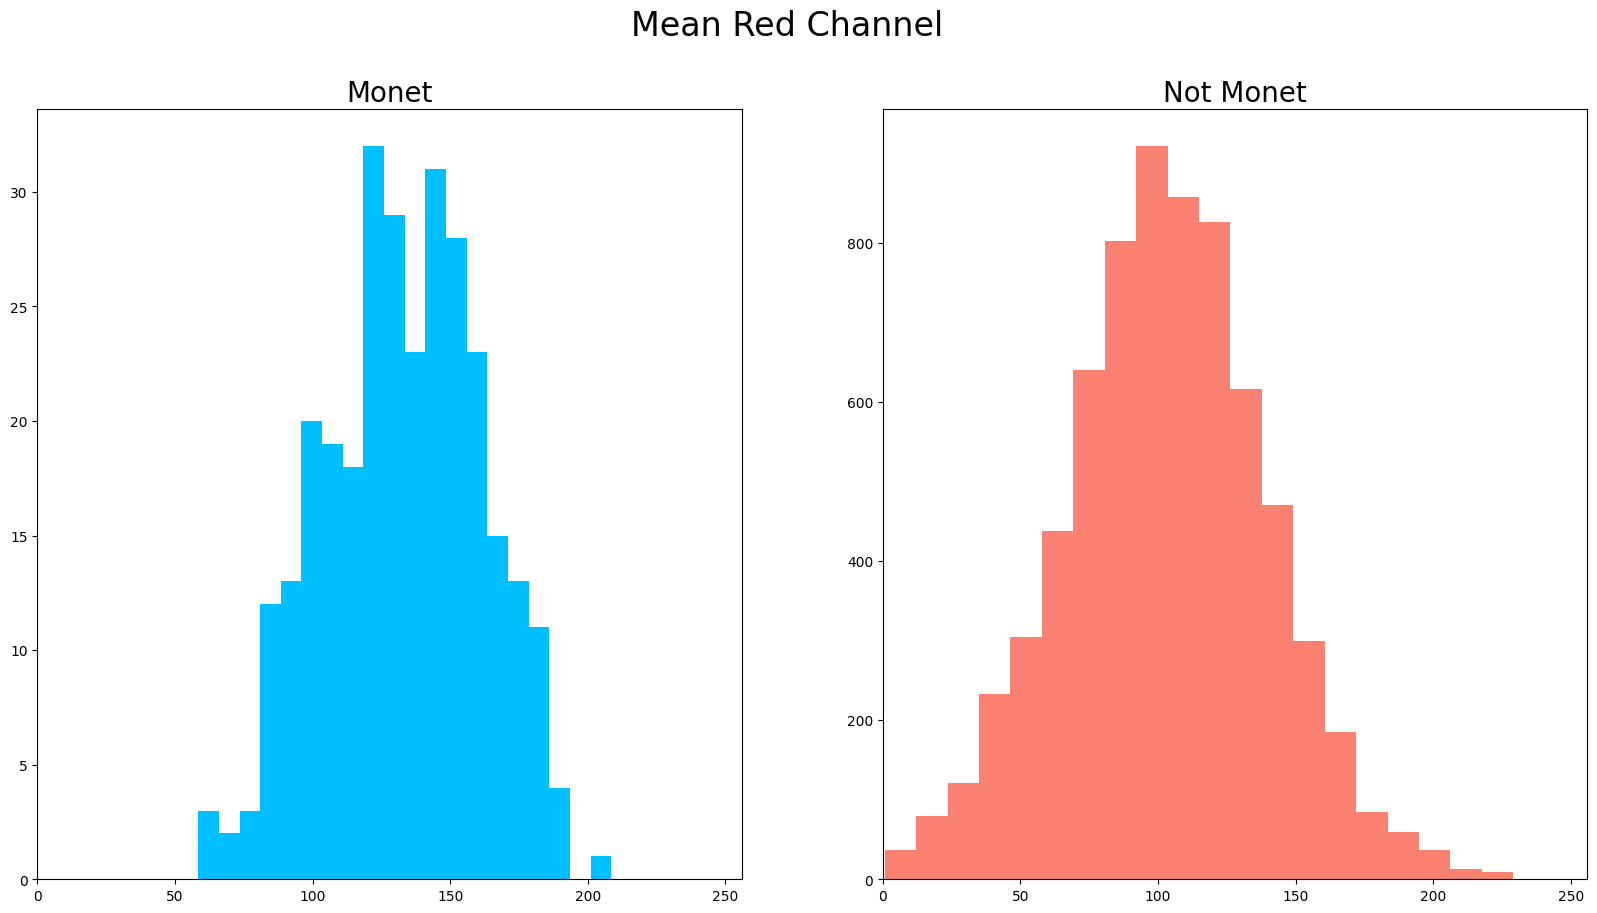

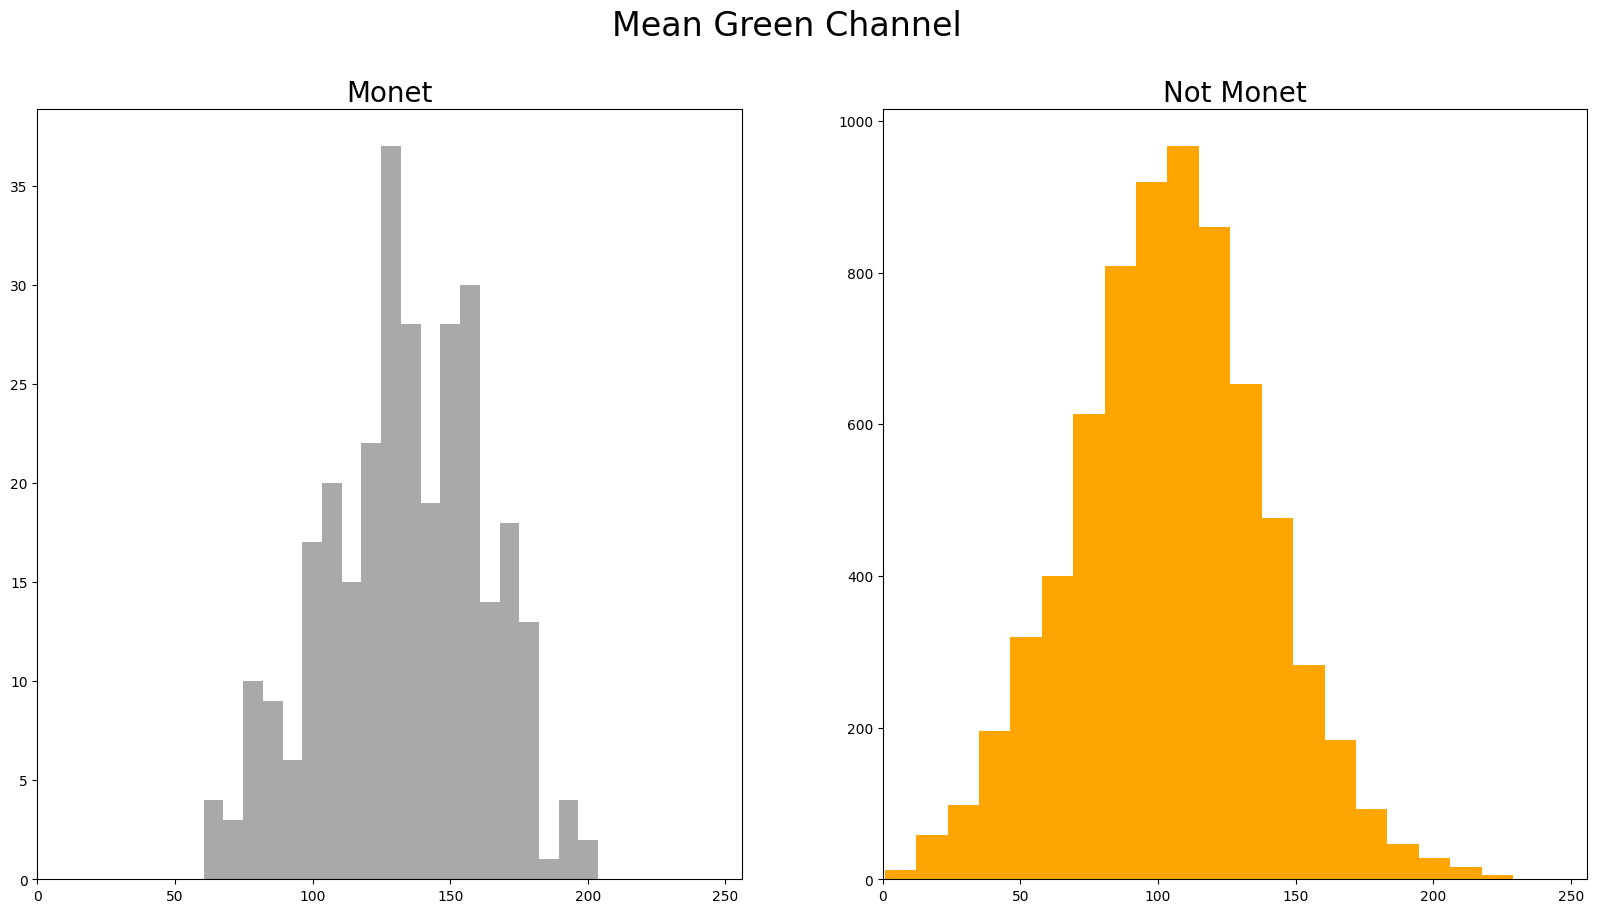

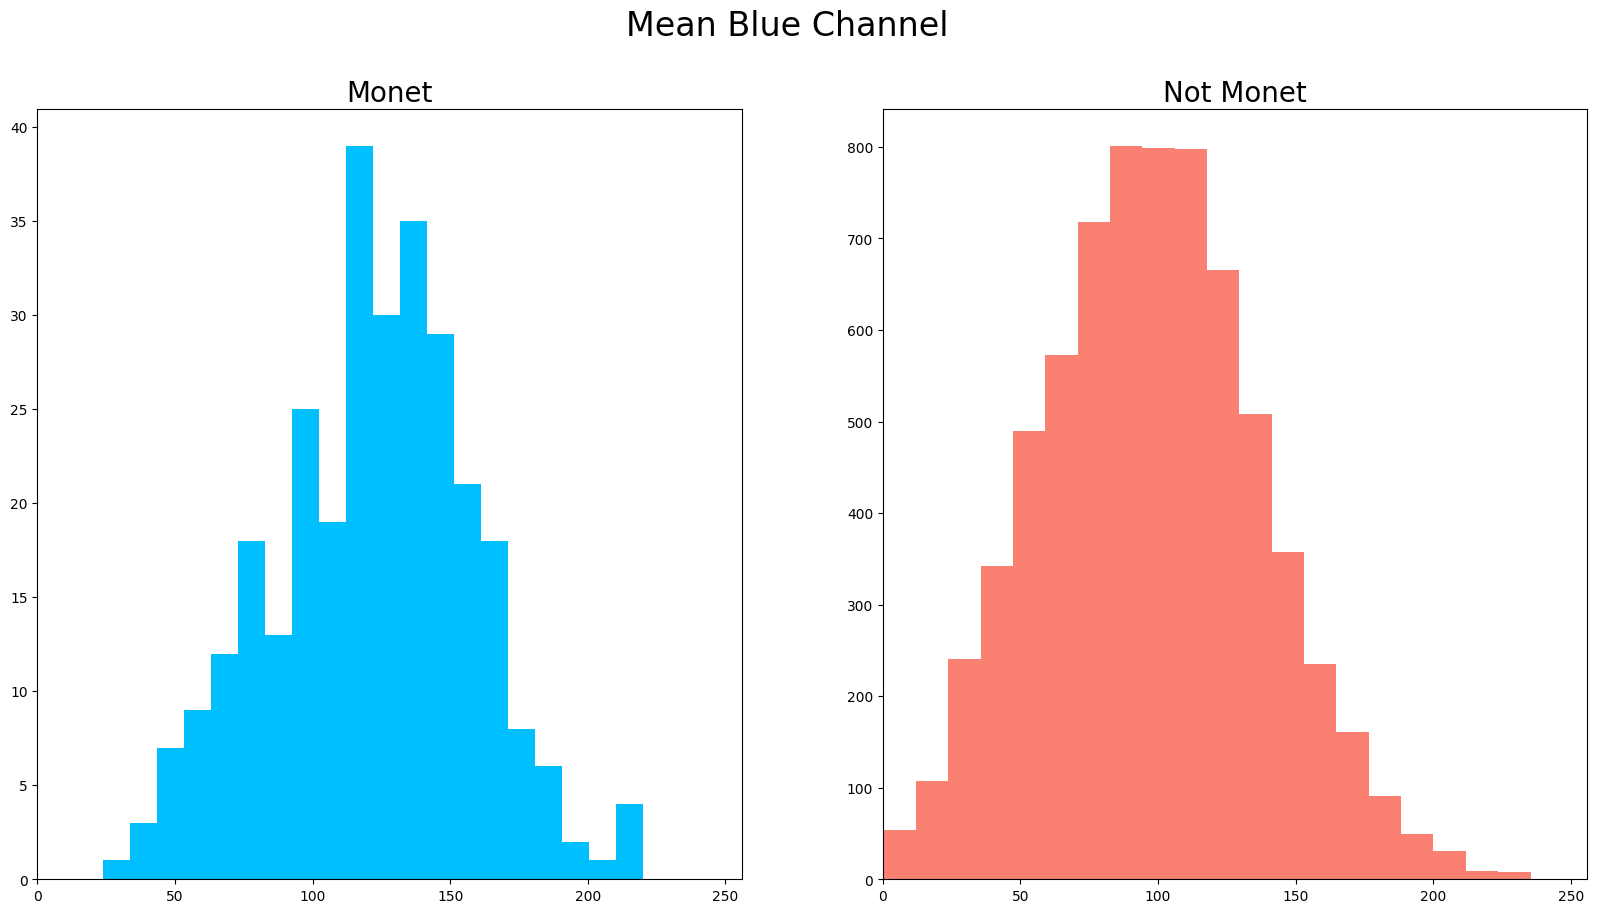

In [10]:
# Mean All
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_all_channels_monet, bins=20, color='darkgray');
axes[1].hist(mean_all_channels_photo, bins=20, color='orange');
fig.suptitle('Mean All Channels', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);


# Mean Red
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_red_channel_monet, bins=20, color='deepskyblue');
axes[1].hist(mean_red_channel_photo, bins=20, color='salmon');
fig.suptitle('Mean Red Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);


# Mean Green
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_green_channel_monet, bins=20, color='darkgray');
axes[1].hist(mean_green_channel_photo, bins=20, color='orange');
fig.suptitle('Mean Green Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);


# Mean Blue
fig, axes = plt.subplots(
    1
    , 2
    , figsize=(20,10)
)

axes[0].hist(mean_blue_channel_monet, bins=20, color='deepskyblue');
axes[1].hist(mean_blue_channel_photo, bins=20, color='salmon');
fig.suptitle('Mean Blue Channel', fontsize=24)
axes[0].set_title('Monet', fontsize=20);
axes[1].set_title('Not Monet', fontsize=20);
axes[0].set_xlim([0,256]);
axes[1].set_xlim([0,256]);

The sum distributions all look somewhat normally distributed. The photo images have a wider distribution. The photo images also look slightly shifted to the left. We also see a more unified and clear peak usually across three bins in the photo images. One thing to call out is that we have significantly more photo images than Monet images, so we may be running into a scenario where too little data on the Monet plots shows up as false shape signals. We also need to be careful in that we are comparing Monet images to non-Monet images, but the actual test of the model will be to transform the non-Monet images into Monet images. What we see here is some evidence that there is at least a difference between the Monet and non-Monet images to start with.

The same trends of wider distributions, left-shifted distributions, and more solid peaks apply as well for the mean plots. Of the two, I prefer the mean plots to the sum plots. Each of the RGB channels have their peaks around 100 for mean pixel value for the photo images. It is a little murkier for the Monet images, with the peaks not being as thoroughly defined as in the photo images, though the mean does look higher.

It is not quite clear yet what exploratory analysis will help for cleanup or for modeling since the image data looks clean as of now and because much of what we would like to look at are the modified or generated images from the GAN, but we do not have those before modeling. So, we can return back to EDA if we run into more during modeling that needs further exploration.

So, for now, we will jump into modeling.

## Modeling

(My overall take on GANs to start here comes from what I learned in the Introduction to Generative AI course in the MSCS curriculum but available as an elective for MSDS students.)

We will use GANs for modeling. A generative adversarial network (GAN) is a machine learning approach or architecture (network) that leverages two neural networks that compete against one another (adversarial) to generate (generative), in this project, new images. The two networks are the generator and the discriminator.

The GAN takes in a training set of images, in this case the Monet images. The generator starts out by creating random noise, a mapping to random pixels. The discriminator then takes the generator's images and the training set and tries to discriminate the two from one another, classifying both the real and fake images into real and fake labels by drawing discrimination boundaries that keep in the real images and keep out the fake images. The generator takes the feedback from the discriminator and tries to move the fake images closer towards the real images, adjusting pixels to get them closer and eventually beyond the discrimination boundary. This back and forth cycle repeats until the generator if able to create images that are close enough to the real images that the discriminator can no longer tell them apart. At that stage, we have trained a generator to take in inputs and output real images, real meaning indistinguishable from the training images to the discriminator.

CycleGAN transforms an image to match characteristics found in another image. The common example from the original research paper for CycleGAN is using this model to take an image of a horse as input and output the same image but with a zebra and vice versa.

We will stick with CycleGAN for this iteration of the project. The main alternative that I would like to test out in future iterations is creating new images from scratch with Monet characteristics, not applying Monet-like transformations to a set of input images.

Image-to-image translation -- converting one image into a modification of another -- typically requires paired images with the change between the pairs being what we want the model to encode and then apply to a new set of input images. The requirement to have these pairs of images for training is pretty onerous. One way around this would be to perform image-to-image translation without needing the paired images. In this case, we could have input images that demonstrate the translation we want to apply but without the translation being applied to the same images.

For example, if we want to convert winter scenes into summer scenes, paired image-to-image translation asks us to provide pairs of images where the training set has images of the same scene but with one in winter and the other in summer. We would like to remove this requirement of needing the same training images in both domains of summer and winter, instead only needing training images in each domain in general but not the same image in each domain. This is called unpaired image-to-image translation. Unpaired translation is an unsupervised approach, excepting the fact that we have two labeled sets in terms of the domain we are looking for the model to pick up on, whereas paired translation is a supervised one.

CycleGANs perform unpaired image-to-image translation, identifying the characteristics of winter and summer in the images without needing to have pairs of images in both seasons, and then it lets us apply the translation from one season to another to new input images. Since this project has unpaired images in the training set, it lends itself to use of CycleGANs for translating the style of images in one domain to the other, from non-Monet style to Monet style.

### CycleGAN Architecture

To explain here, we will use two domains of images: summer and winter.

CycleGANs add extra pieces to the base GAN architecture to accommodate unpaired data. 

CycleGANs use two generators and two discriminators, or, alternatively, two GANs. We are interested in image translation in both directions, so we train a GAN in each direction. While being able to translate images in both directions may be useful, CycleGAN uses this bi-directional architecture to minimize cycle consistency loss. (Note that cycle consistency loss is also called reconstruction error). We explore cycle consistency when we feed a summer image into the model to get a winter image, and then we take that winter image and send it back through the second model to convert it back into a summer image. We then compare how different the image that went both ways through the model is to the original summer image. Cycle consistency loss is the difference between these two images.

Cycle consistency is required to address mode collapse. This is when the generators keep producing the same output image regardless of the input. Some CycleGANs resulted in the generators learning that they can beat the discriminators by producing the same output image each time. When we translate the output image back through the model in the opposite direction and compare that output with the original input, we make sure the model does not fall victim to mode collapse.

One interesting aspect of cycle consistency is that it gives us paired data. The intermediate state gives us an image in the opposite season. Once the model is trained and accurate, we end up with pairs of images in both seasons.

Combining the previous two forms of loss, the objective function includes the adversarial loss of the first generator, the adversarial loss of the second generator, and the cycle consistency loss.

For photo generation from paintings, we include an additional loss: identity loss. We measure identity loss when we take a summer image and pass it through the GAN that converts winter images to summer images. Since we are starting with a summer image, the translation should not affect the output, meaning the "generated" summer image that moves through the model should match the original summer image. CycleGAN also minimizes identity loss as part of its objective function.

So far we have focused on the role of the two generators. The discriminators use PatchGAN. PatchGAN functions like normal discriminators but at a zoomed out level. An implementation of PatchGAN may use 70x70px patches (as the original CycleGAN paper does). This means that instead of the discriminator returning a single score for classifying the entire image at once, it instead provides a score for each 70x70 patch, moving across the image like a convolutional filter. It then averages each of the responses to provide a single discriminator value.

The original GAN paper also provides architecture decisions such as using 3 convolutional layers in the generators, using 9 residual blocks in the intermediate layers, using instance instead of batch normalization, and more. We may use some or all of these decisions in our modeling below.

There are two other interesting items to call out before jumping into modeling. First is that many CycleGAN implementations use a U-Net architecture. This architecture uses convolutional layers to downsample, transposed convolutions to upsample, and skip connections between different layers. Downsampling in this context is reducing the size of the data, and upsampling is increasing it. Note that the original GAN paper uses a residual neural network (ResNet) instead of a U-Net.

The last interesting item is that we can think of CycleGANs as adversarial autoencoders. Autoencoders are models that convert an input to a reduced or translated space and then convert that reduced or translated space back to the original in encoding and decoding cycles. We can think of CycleGANs as encoding an image to the style of the other image as the encoding step. We then engage the cycle consistency step by converting the translated image back to the original domain.

CycleGANs can capture the characteristics and style of a collection of works, not just the style of one work. In this project, we are capturing the style of Monet paintings and converting input photos into the style of those paintings. We will largely follow the TensorFlow CycleGAN and pix2pix tutorial in the references section below. Due to the complexity of what we are building and how many hyperparameters we can change, we will stick closely to the TensorFlow tutorial. 

I will likely try to do more linking between the code and the theory rather than deviating way off track from the code. Not sure if we are supposed to code our own CycleGAN solution from scratch, but that seems like a stretch due to the complexity of the model.

Let's get to building. 

From the original paper

Generators
- 3 convolutional layers
- several residual blocks (9 blocks for 256x256 images)
- two fractionally-strided convolutions with stride 1/2
- one convolution that maps features to RGB
- instance normalization

Discriminators
- 70x70 PatchGANs that aim to classify if if 70x70 overlapping image patches are real or fake

Overall
- Replace negative log-likelihodd with a least-squares loss
- Adam
- Adam solver with batch size of 1
- Batch size 1
- Train discriminators on history of generated images, not just most recent ones
- lambda=10
- 0.0002 learning rate with decay after 100 epochs and decaying to 0 over the next 100 epochs

### Gimme a Generator

First we build the generator. Keras's community implementation of instance normalization is deprecated, but they point to this spreadsheet that indicates that we can use GroupNormalization with groups=-1 to recreate instance normalization.

https://docs.google.com/spreadsheets/d/1YMPudb7Otqx_TQu_oTHMm5IRZolyPcah8-qkMs_wI-I/edit?gid=0#gid=0

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GroupNormalization

In the TensorFlow docs, check out the third paragraph after the block with default values to confirm how to perform instance normalization.

We mirror the test in the TensorFlow docs by encoding an image. One pass of the encoder trims the image dimensions in half for each dimension due to the strides parameters in the convolutional layer. We then decode the encoded image, expanding the autoencoder code layer back out to the input image's original dimensions.

In [27]:
def encode(n_filters, filter_size):
    # Randomly initializes a tensor with unknown dimensions beforehand
#     init = tf.random_normal_initializer(0., 0.02) # We can look at changing this initialization
    
    return models.Sequential([
        layers.Conv2D(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        # Unlike the pix2pix tutorial, we want instance normalization for all encoders
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
    ])

def decode(n_filters, filter_size):
    return models.Sequential([
        # We are reversing the operations of the encoder, so we match the parameters
        layers.Conv2DTranspose(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        # The tutorial applies 0.5 dropout to the first three layers only
        , layers.Dropout(0.25) # We can play with this as another hyperparameter to explore
        # We use ReLU instead of LeakyReLU here since we want the decoder output to be positive
        , layers.ReLU()
    ])

In [28]:
print(encode(3, 4)(tf.expand_dims(next(iter_monet), 0)).shape)
print((decode(3, 4)(encode(3,4)(tf.expand_dims(next(iter_monet), 0)))).shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


To repeat, the functions above create the encoder and decoder functions for an autoencoder. The goal is to repeat each of these as much as needed to produce the desired latent information layer in between. This autoencoder setup is the foundation for the U-Net that takes the place of the ResNet in the original CycleGAN paper. But we still need to add in the repeated encodings and decodings along with the skip connections to fill out the U-Net.

Note that we deviate from the TensorFlow pix2pix tutorial in that we include instance normalization on all encode steps instead of batch normalization on a subset. We also apply a dropout layer with a 0.25 dropout frequency parameter instead of applying dropout only to the first three layers.

Next we need to combine the encoding and decoding steps into a generator model, implementing the full U-Net. We will encode the input image down to a 1x1 output with 512 (or however many filters we choose) channels. We then build the image back up to original dimensions and channels.

It is not clear to me yet if we should treat the number of filters and the size of the filters as hyperparameters to test out. These values seem pretty common, but it may be that all the sources I am looking at are copying a smaller number of sources that used these values. But, these are both hyperparameters we can return to to see what happens if we play with them.

We track the skips list so we can add the output of a decoding layer with the output of the matching encoding layer. For instance, if we have 10 input layers, we encode each in order. Then, when we decode the first layer in the decoding stack, that corresponds to the final output layer of the encoding stack. We add the output of the decoding stack to the second-to-last output of the encoding stack, so we line up the decoding of the original layer 10 encoding with the output of the original layer 9 encoding. This applies the version of skip connections that we use in U-Net.

In [37]:
def generator():
    encoding_stack = [
                         # Comments show output image dimensions minus number of filters
        encode(64, 4)    # 128x128
        , encode(128, 4) # 64x64
        , encode(256, 4) # 32x32
        , encode(512, 4) # 16x16
        , encode(512, 4) # 8x8
        , encode(512, 4) # 4x4
        , encode(512, 4) # 2x2
        , encode(512, 4) # 1
    ]
    
    decoding_stack = [
        decode(512, 4)   # 2x2
        , decode(512, 4) # 4x4
        , decode(512, 4) # 8x8
        , decode(512, 4) # 16x16
        , decode(256, 4) # 32x32
        , decode(128, 4) # 64x64
        , decode(64, 4)  # 128x128
    ]
    
    final_decoding_layer = layers.Conv2DTranspose(
        3
        , 4
        , strides=2
        , padding='same'
        , activation='tanh'
    )                    # 256x256
    
    inputs = layers.Input((256, 256, 3))
    
    translated_images = inputs
    
    # Apply each encoding layer to the inputs, passing the encoding output as the next input
    skips = []
    for endecoder in encoding_stack:
        translated_images = endecoder(translated_images)
        skips.append(translated_images)
        
    # We need to line up the associated output to add together for the skip connections
    skips = reversed(skips[:-1])
    
    # Apply each decoding layer and combine with the matching output from the encoding loop
    for decoder, skip in zip(decoding_stack, skips):
        translated_images = decoder(translated_images)
        translated_images = layers.Concatenate()([translated_images, skip])
        
    # This spreads the image back out to three channels and full 256x256 dimensions
    translated_images = final_decoding_layer(translated_images)
    
    return tf.keras.Model(inputs=inputs, outputs=translated_images)    

Again, to check against the tutorial output, we see that the autoencoder is working as expecting. We repeatedly encode down to a 1x1x512 representation of an input image. We then repeatedly decode while adding skip connections to decoding outputs to get back up to a 256x256x3 generated image. It seems obvious to me now, but the generated image we are looking for is the the decoding layers applied to the 1x1x512 input. We just happen to choose an architecture where we first convert an image into that 1x1x512 representation, but it helps me to think of the generation as really being that second half with the autoencoder, though technically it is the entire model.

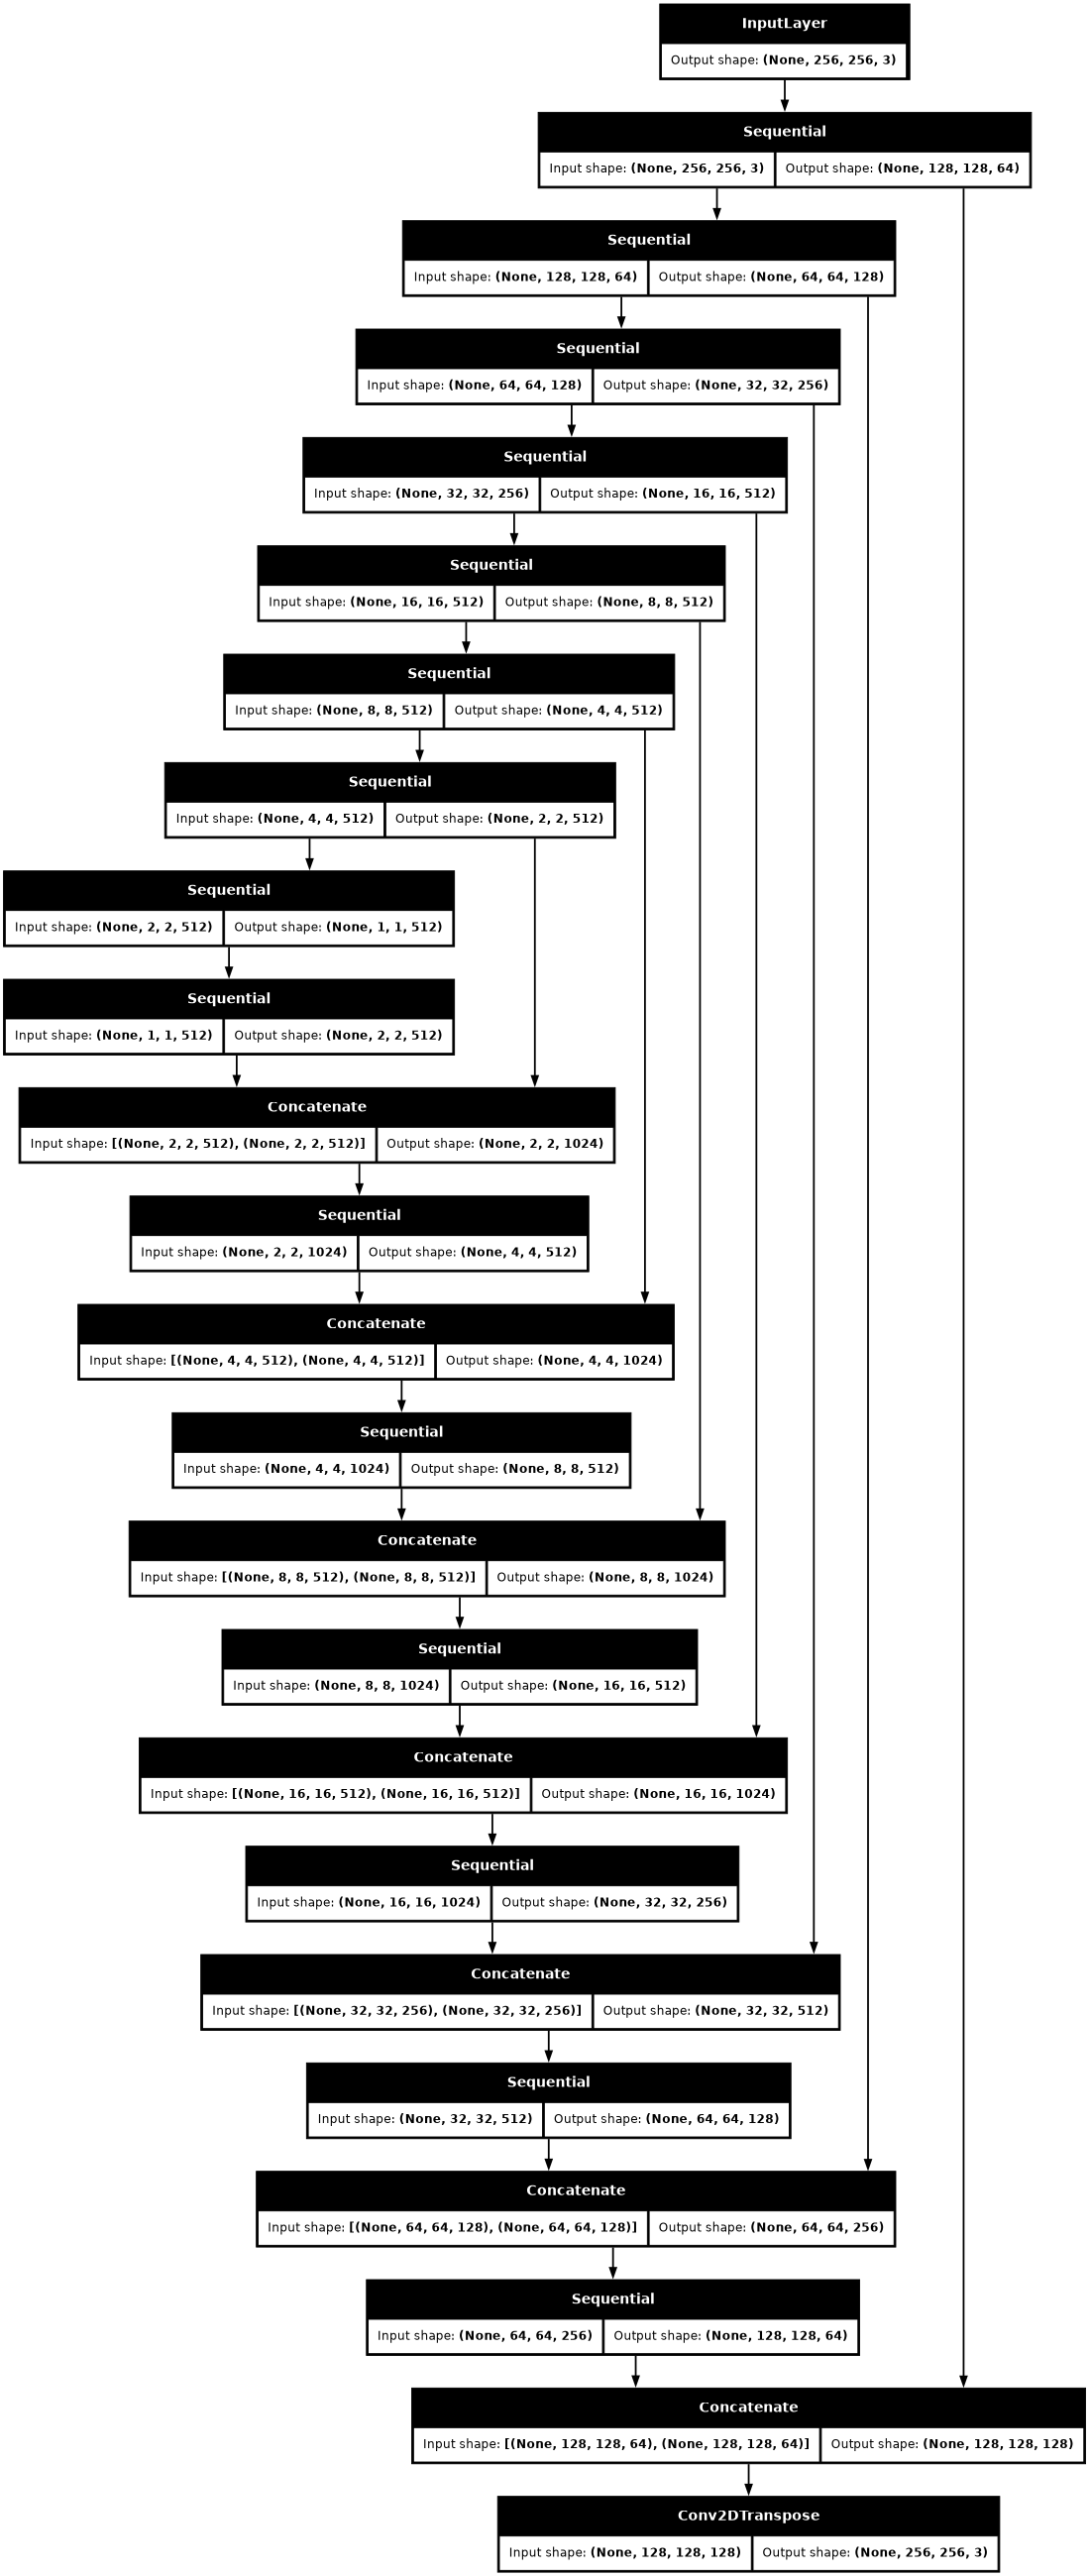

In [38]:
generator = generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

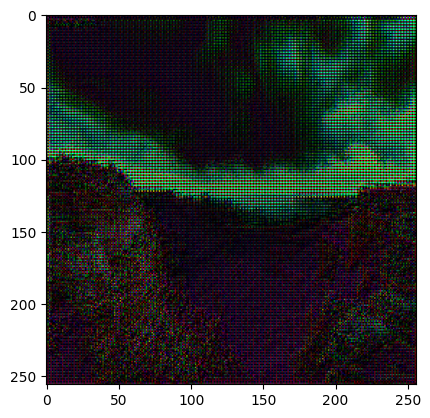

In [42]:
plt.imshow(generator(next(iter_monet)[tf.newaxis, ...], training=False)[0,...]);

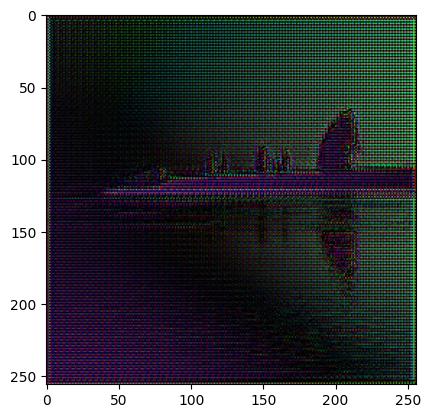

In [43]:
plt.imshow(generator(next(iter_photo)[tf.newaxis, ...], training=False)[0,...]);

### Are There Any Discriminators Out There?

### But What If I Lose?

While we are on the generator, we will define the generator loss. We will now pivot from the pix2pix tutorial back to the CycleGAN tutorial. pix2pix has labeled pairs, and it passes those into the loss function. CycleGAN does not have paired data, so we need an alternative way to line up two images to calculate loss. In walk cycle consistency (described earlier) and cycle consistency loss, though the general loss approach is similar to what we see in pix2pix.

We will use sigmoid cross-entropy loss. Sigmoid cross-entropy is similar to cross-entropy in that it compares the output distribution to the real distribution, but it produces a probability from the output of the model rather than 0s or 1s. In this case, we are comparing the input images to the translated and reverse-translated images with cycle consistency loss, so all the real images are 1s.

The discriminator loss follows similar logic, but it compares separate real and generated image losses. We compare the real images against a tensor of 1s and the generated images against a tensor of 0s since we know which are real and which are generated.

In [ ]:
def generator_loss(generated_images):
    # from_logits tells the loss function to apply the sigmoid activation function
    losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(generated_images)
        , generated_images
    )
    
def discriminator_loss(real_images, generated_images):
    loss_real = BinaryCrossentropy(from_logits=True)(tf.ones_like(real_images), real_images)
    loss_generated = BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_images), generated_images)
    return (real_loss + generated_loss) * 0.5

## Results

images.zip with 7,000 - 10,000 256x256 images for competition submission

This competition uses the Memorization-informed Fréchet Inception Distance (MiFID) score to evaluate submissions. This is a variant of the Fréchet Inception Distance (FID). (



FID measures the distance between two distributions by extracting features from images, modeling distributions around those features, and then comparing those distributions to determine how far apart they are.



We are hoping for a smaller MiFID.

## Conclusion

## References

Working with TensorFlow TFRecords
- https://www.tensorflow.org/tutorials/load_data/tfrecord
- https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564

Evaluation metrics
- https://arxiv.org/abs/1706.08500 (FID)
- https://www.kaggle.com/c/generative-dog-images/overview/evaluation (MiFID)

GANs
- https://www.geeksforgeeks.org/generative-adversarial-network-gan/
- https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
- https://machinelearningmastery.com/what-is-cyclegan/
- https://neptune.ai/blog/gan-loss-functions
- https://www.geeksforgeeks.org/spatial-resolution-down-sampling-and-up-sampling-in-image-processing/
- https://www.youtube.com/watch?v=5jziBapziYE

Original CycleGAN paper and docs from original authors
- https://junyanz.github.io/CycleGAN/
- https://arxiv.org/pdf/1703.10593

CycleGAN references used to build the models above
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://www.youtube.com/watch?v=4LktBHGCNfw (CycleGAN implementation)
- https://hardikbansal.github.io/CycleGANBlog/
- https://www.youtube.com/watch?v=2MSGnkir9ew
- https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

Saving Models
- https://www.tensorflow.org/tutorials/keras/save_and_load
- https://machinelearningmastery.com/save-load-keras-deep-learning-models/